# Downsampling
Here a model trained on 15 min resolution data is tested on data at 15 min resolution.

In [119]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [120]:
sample_length = 32


Testing on house 2

In [121]:
aggregate_power = pd.read_csv('../master_data/house_2/channel_1.dat', header = None,
                                names = ["Time","Power"], delim_whitespace = True,
                                index_col = 0)
aggregate_power.index = pd.to_datetime(aggregate_power.index,unit='s')

kettle_power = pd.read_csv('../master_data/house_2/channel_8.dat', header = None,
                                names = ["Time","Power"], delim_whitespace = True,
                                index_col = 0)


kettle_power.head()

/home/bjornif/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Power
Time,
1361116822,0
1361116825,0
1361116831,0
1361116837,0
1361116843,0


In [122]:
def get_activations(power_series, min_off_duration=30, min_on_duration=12,
                        border=1, power_threshold=200):
    activations = []
    signal_start = None
    signal_end = None
    no_signal = 0
    current_signal = []
    series_length = len(power_series)
    series_length_percent = int(len(power_series)/100)
    measurements_processed = 0
    
    power_series.index = pd.to_datetime(power_series.index,unit='s')
    min_off_duration = pd.Timedelta(str(min_off_duration) + 's')
    min_on_duration = pd.Timedelta(str(min_off_duration) + 's')
    timestep = pd.Timedelta('6s')
    
    for time in power_series.index:
        measurement = power_series.loc[time]['Power']
        measurements_processed +=1
        
        if measurements_processed % series_length_percent == 0:
            print(str(measurements_processed/series_length_percent) + '%')
        
        if (measurement >= power_threshold):
            if signal_start is None:
                signal_start = time - timestep
            no_signal = 0
            current_signal.append(measurement)
            signal_end = time + timestep
            
        else:
            if signal_end is not None:
                no_signal = time - signal_end
                if (no_signal >= min_off_duration) and (signal_start is not None):
                    if (signal_end - signal_start) > min_on_duration:
                        mean_power = np.mean(current_signal)
                        activations.append([signal_start,signal_end,mean_power])
                    current_signal = []
                    signal_start = None
                    signal_end = None
    
    return activations

In [5]:
kettle_activations = get_activations(kettle_power)

1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
100.0%


In [6]:
kettle_activations_pd = pd.DataFrame(kettle_activations, columns = ['start','end','mean_power'])
kettle_activations_pd['start'] = pd.to_datetime(kettle_activations_pd['start'])
kettle_activations_pd['end'] = pd.to_datetime(kettle_activations_pd['end'])

kettle_activations_pd.head()

,start,end,mean_power
0,2013-04-17 08:01:11,2013-04-17 08:03:11,2846.210526
1,2013-04-17 16:23:28,2013-04-17 16:26:22,3016.071429
2,2013-04-17 19:11:30,2013-04-17 19:15:12,2897.971429
3,2013-04-17 20:40:15,2013-04-17 20:43:21,2998.500000
4,2013-04-18 15:32:01,2013-04-18 15:35:01,3007.241379


2013-04-26 06:22:03 2013-04-26 06:25:39


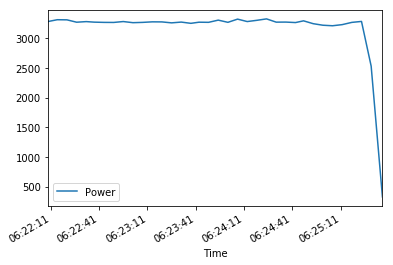

In [7]:
for _ in range(1):
    dice = np.random.randint(0,100)
    start = kettle_activations_pd.iloc[dice]['start']
    end = kettle_activations_pd.iloc[dice]['end']
    print(start,end)
    aggregate_power[start:end].plot()
    plt.show()

In [89]:
def clean_power_series(aggregate_power, activations):
    
    temp_ap = aggregate_power.copy()
    
    n = activations.shape[0]

    #pcent = int(n/100)
    ap_sans_activations = pd.DataFrame()
    
    ap_sans_activations.append(temp_ap[:activations['start'][0]])
    
    for i in range(1,n):
        ap_sans_activations = ap_sans_activations.append(temp_ap[activations['end'][i-1]:activations['start'][i]])
    
    ap_sans_activations.append(temp_ap[activations['end'][i]:])
    
    return ap_sans_activations


def create_training_set(aggregate_power, activations, ap_sans_activations = None, sample_length = 128, pad = 1024):
    training_set = pd.DataFrame(columns = np.linspace(0,1,sample_length))
    training_set_response = pd.DataFrame(columns = ['start','end','mean_power'])

    #aggregate power sans the activation intervals
    if ap_sans_activations is None:
        ap_sans_activations = clean_power_series(aggregate_power,activations)

    n = aggregate_power.shape[0]
    j = 0
    for i in range(activations.shape[0]):
        if i % 100 == 0:
            print(i)
        while True:
            dice = np.random.random()
            if dice < 0.5:
                start = activations['start'][i]
                end = activations['end'][i]
                #randomly place the chosen signal in a window.
                #note that the entire signal is always in the window 
                sample_start = start - pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample_end = end + pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample = aggregate_power[sample_start:sample_end]
                while sample.shape[0] > sample_length:
                    if np.random.random() > 0.5 and end < sample.index[-1]:
                        sample = sample.iloc[:-1]
                    elif start > sample.index[0]:
                        sample = sample.iloc[1:]
                    else:
                        sample = sample.iloc[0:1]
                
                if not sample.shape[0] < sample_length:
                    
                    #sample = sample.reindex(columns=training_set.columns, method='nearest')
                    start_fraction = (start - sample.index[0])/(sample.index[-1] - sample.index[0])
                    end_fraction = (end - sample.index[0])/(sample.index[-1] - sample.index[0])
                    training_set.loc[j] = sample.T.values[0]
                    training_set_response.loc[j] = [start_fraction,end_fraction,activations['mean_power'][i]]
                    j+=1
                
                break
                
                
            ri = np.random.randint(0,ap_sans_activations.shape[0]-sample_length)
            sample = ap_sans_activations.iloc[ri: ri+sample_length]
            training_set.loc[j] = sample.T.values[0]
            training_set_response.loc[j] = [0,0,0]
            j+=1
            
    return training_set, training_set_response



In [111]:
#downsample the input:
aggregate_power_15m = aggregate_power.resample('15min').mean()
print(aggregate_power.shape, aggregate_power_15m.shape)
aggregate_power_15m.head()

(2780373, 1) (22517, 1)


,Power
Time,
2013-02-17 16:15:00,433.016393
2013-02-17 16:30:00,483.034247
2013-02-17 16:45:00,968.544828
2013-02-17 17:00:00,521.678082
2013-02-17 17:15:00,650.234483


In [112]:
aggregate_power_15m = aggregate_power_15m.dropna()
aggregate_power_15m.shape

(19185, 1)

In [113]:
clean_ap = clean_power_series(aggregate_power_15m,kettle_activations_pd)

In [114]:
X, y = create_training_set(aggregate_power_15m, kettle_activations_pd,
                                            ap_sans_activations = clean_ap,
                                            sample_length = sample_length, pad = 40000)
X.head()

0
100
200
300
400
500
600
700


,0.0,0.0322580645161,0.0645161290323,0.0967741935484,0.129032258065,0.161290322581,0.193548387097,0.225806451613,0.258064516129,0.290322580645,...,0.709677419355,0.741935483871,0.774193548387,0.806451612903,0.838709677419,0.870967741935,0.903225806452,0.935483870968,0.967741935484,1.0
0,129.075342,176.808219,130.513699,151.349315,151.856164,127.232877,170.636986,1054.638889,965.605442,475.863014,...,973.383562,243.452055,206.979452,182.273973,231.760274,828.452055,1078.595890,263.363014,203.315068,187.150685
1,124.212329,182.482517,149.921429,270.028169,281.616438,219.255172,244.082192,287.684932,217.226027,246.958042,...,268.118056,222.343066,218.303448,268.500000,261.818182,258.390071,303.091549,263.811189,230.811594,317.302817
2,172.095890,132.731034,169.568493,155.253425,135.582192,187.041096,139.006849,149.438356,169.234483,135.130137,...,135.931507,163.047945,162.376712,134.705479,177.273973,141.541096,565.753425,253.006849,205.397260,203.986301
3,176.958621,147.765517,123.813793,168.441379,121.337931,141.236111,168.137931,251.234483,294.558621,423.881944,...,262.437500,236.986207,270.193103,365.606897,230.068966,302.439716,258.600000,331.434483,390.372414,333.689655
4,132.787671,167.075342,145.732877,133.157534,181.095890,172.054422,279.280822,281.952055,211.986301,257.465753,...,2358.861842,1211.837838,1851.536913,721.312925,338.210884,948.924658,315.006849,295.609589,266.523810,265.705479


In [123]:
from keras.models import load_model

model = load_model('../master_data/nilm/models/model0122ds15.h5')


In [124]:
normalization = pd.read_csv('../master_data/nilm/normalization_params.csv', header=0, delim_whitespace=True)
normalization.head()

,mean,sd
0,[[[ 505.60967371]]\n\n [[ 250.21105381]]\n\n [...,242.646964


In [125]:
X_np = np.array(X).reshape((X.shape[0],X.shape[1],1))
y_np = np.array(y).reshape((y.shape[0],y.shape[1]))

#mean = normalization['mean'].values[0]
mean = X_np.mean(axis=1).reshape(X_np.shape[0],1,1)
X_np = X_np - mean
sd = normalization['sd'].values[0]
#rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
X_np /= sd
print("Mean: ", X_np.mean())
print("Std: ", X_np.std())


Mean:  1.11022302463e-17
Std:  1.39754053785


(1320, 1)


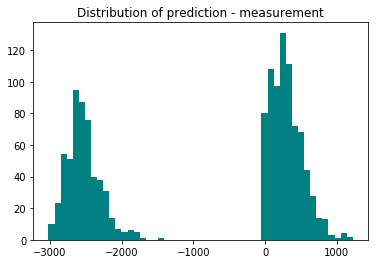

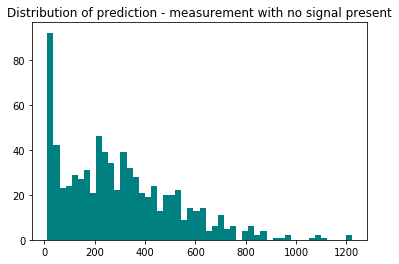

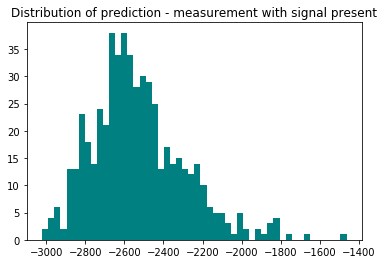

In [126]:

pred = model.predict(X_np)

#Scale experiment:
pred[:,0] = pred[:,0]/1000
pred[:,1] = pred[:,1]/1000

diff_power = pred[:,2] - y_np[:,2]
diff_power = diff_power.reshape(diff_power.shape[0],1)
diff_clean = pred[:,2][y_np[:,2] == 0] - y_np[:,2][y_np[:,2] == 0]
diff_clean = diff_clean.reshape(diff_clean.shape[0],1)
diff_signal = pred[:,2][y_np[:,2] != 0] - y_np[:,2][y_np[:,2] != 0]
diff_signal = diff_signal.reshape(diff_signal.shape[0],1)

print(diff_power.shape)

plt.hist(diff_power,bins=50, color='teal')
plt.title("Distribution of prediction - measurement")
plt.show()

plt.hist(diff_clean,bins=50, color='teal')
plt.title("Distribution of prediction - measurement with no signal present")
plt.show()

plt.hist(diff_signal,bins=50, color='teal')
plt.title("Distribution of prediction - measurement with signal present")
plt.show()

The model is now extremely poor.

Best F1:  0.624256837099


/home/bjornif/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


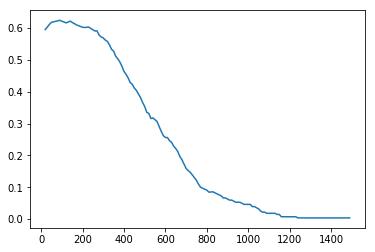

In [127]:
#F1 score = 2*(recall*precision)/(recall+precision)
signal_present_gold = np.zeros(pred.shape[0])
signal_present_gold[np.where(y_np[:,2] > 0)] = 1
accs = []
thresholds = np.arange(20,2000,10)

for i in thresholds:
    signal_present_pred = np.zeros(pred.shape[0])
    signal_present_pred[np.where(pred[:,2] >= i)] = 1
    
    precision = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_pred)
    recall = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_gold)
    f1 = 2*(recall*precision)/(recall+precision)
    
    accs.append(f1)
    
print("Best F1: ", max(accs))
plt.plot(thresholds,accs)
plt.xticks = thresholds
plt.show()


The maximum F1 score has now dropped to approximately .62

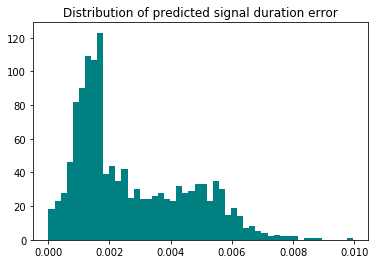

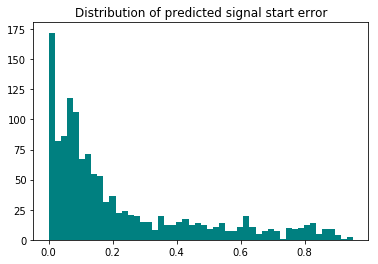

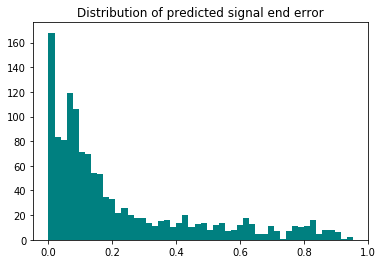

In [128]:
#Error in duration:

duration_pred = pred[:,1] - pred[:,0]
duration_measured = y_np[:,1] - y_np[:,0]
sane_index = np.where(np.logical_and(duration_pred < 1,duration_pred > 0))
sane_duration_pred  = duration_pred[sane_index]
sane_duration_measured = duration_measured[sane_index]

duration_mae = np.abs(duration_pred - duration_measured)
duration_mae = duration_mae.reshape(duration_mae.shape[0],1)
sane_duration_mae = np.abs(sane_duration_pred - sane_duration_measured).mean()

plt.clf()
plt.hist(duration_mae,bins = 50, color='teal')
plt.title("Distribution of predicted signal duration error")
plt.show()

start_diff = np.abs(pred[:,0] - y_np[:,0])
start_diff = start_diff.reshape(start_diff.shape[0],1)

plt.hist(start_diff,bins = 50, color='teal')
plt.title("Distribution of predicted signal start error")
plt.show()

end_diff = np.abs(pred[:,1] - y_np[:,1])
end_diff = end_diff.reshape(end_diff.shape[0],1)

plt.hist(end_diff,bins = 50, color='teal')
plt.title("Distribution of predicted signal end error")
plt.show()

The predicted duration increases, which makes a lot of sense, since the time interval is a lot larger, so most duration fractions will be very small.

## Discussion
### Normalization
A normalization scheme similar to what Kelly proposed - subtracting the mean from each row, but dividing all inputs by the average standard deviation of all rows - seems to work the best. Other normalization schemes tested include no normalization, no centering, neither, centering by average mean and normalizing with random deviations.<br>

### Training
Surprisingly, the model does not seem to benefit much from extensive training, and can be trained in a single epoch to a reasonable degree, taking around 2-3 minutes. This is in stark contrast to the training times reported by Kelly.<br><br>
One neat discovery was that scaling the range of the time components of the output to be the same order of magnitude as the power component, allowed the net to focus more on this part of the loss (now non-neglible). Perhaps the reason this is not more commonly covered in literature is because of the rarity of training multiple regression nets.<br><br>
Also surprising is the fact that by thresholding appropriately I am able to acheive a far better F1 score than Kelly on the kettle.

### Downsampling
Testing a model trained on high-res data on downsampled data yielded poor results.<br>
Training a model on 1 minute resolution data and testing it on the same resolution gave slightly more promising results.<br>
Training a model on 15 minute resolution data and testing it on the same resolution was close to useless.
